# Setup

We need a few different imports, and also the paths to the images we saved in the last notebook of the mel spectograms

In [3]:
from fastai.vision.all import *
import librosa
import librosa.display
from IPython.display import Audio

In [4]:
DATA = Path('../../data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'
AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'
dst_path = DATA/'free-sound/train'
dst_path.ls()

(#42) [Path('../../data/free-sound/train/Saxophone'),Path('../../data/free-sound/train/Cello'),Path('../../data/free-sound/train/Meow'),Path('../../data/free-sound/train/Bus'),Path('../../data/free-sound/train/Laughter'),Path('../../data/free-sound/train/Chime'),Path('../../data/free-sound/train/Bark'),Path('../../data/free-sound/train/Burping_or_eructation'),Path('../../data/free-sound/train/Bass_drum'),Path('../../data/free-sound/train/Harmonica')...]

#####  Some digging to look at the files in the directories

In [5]:
dst_path.ls()

(#42) [Path('../../data/free-sound/train/Saxophone'),Path('../../data/free-sound/train/Cello'),Path('../../data/free-sound/train/Meow'),Path('../../data/free-sound/train/Bus'),Path('../../data/free-sound/train/Laughter'),Path('../../data/free-sound/train/Chime'),Path('../../data/free-sound/train/Bark'),Path('../../data/free-sound/train/Burping_or_eructation'),Path('../../data/free-sound/train/Bass_drum'),Path('../../data/free-sound/train/Harmonica')...]

In [6]:
AUDIO_RECORDINGS.ls()

(#9473) [Path('../../data/freesound-audio-tagging/audio_train/2a871432.wav'),Path('../../data/freesound-audio-tagging/audio_train/704d6fc7.wav'),Path('../../data/freesound-audio-tagging/audio_train/f5729f4f.wav'),Path('../../data/freesound-audio-tagging/audio_train/84d0e459.wav'),Path('../../data/freesound-audio-tagging/audio_train/0b3c0588.wav'),Path('../../data/freesound-audio-tagging/audio_train/56a59a85.wav'),Path('../../data/freesound-audio-tagging/audio_train/f8742dce.wav'),Path('../../data/freesound-audio-tagging/audio_train/1f4a7bfe.wav'),Path('../../data/freesound-audio-tagging/audio_train/151b80e7.wav'),Path('../../data/freesound-audio-tagging/audio_train/c3015f33.wav')...]

In [19]:
!tree -L 1 $dst_path

../../data/free-sound/train
├── Acoustic_guitar
├── Applause
├── Bark
├── Bass_drum
├── Burping_or_eructation
├── Bus
├── Cello
├── Chime
├── Clarinet
├── Computer_keyboard
├── Cough
├── Cowbell
├── Double_bass
├── Drawer_open_or_close
├── Electric_piano
├── Fart
├── Finger_snapping
├── Fireworks
├── Flute
├── Glockenspiel
├── Gong
├── Gunshot_or_gunfire
├── Harmonica
├── Hi-hat
├── Keys_jangling
├── Knock
├── Laughter
├── Meow
├── Microwave_oven
├── Oboe
├── path.pkl
├── Saxophone
├── Scissors
├── Shatter
├── Snare_drum
├── Squeak
├── Tambourine
├── Tearing
├── Telephone
├── Trumpet
├── Violin_or_fiddle
└── Writing

41 directories, 1 file


# Datablock and Dataloader

To create a dataloader, we need a DataBlock. The data block encapsulates the bits needed to build the DataLoader. As can be seen above, all the images are stored in a directory where the parent folder is the label. Therefore we specify in the datalaoder that it will get the label from it's parent `get_y=parent_label`. We also specifies the item transforms to resize the image. 

Now we are able to batch the items together and convert our `DataBlock` to a `DataLoader` object.

In [20]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
dls = dblock.dataloaders(dst_path)

##### Show a batch of images in the dataloader

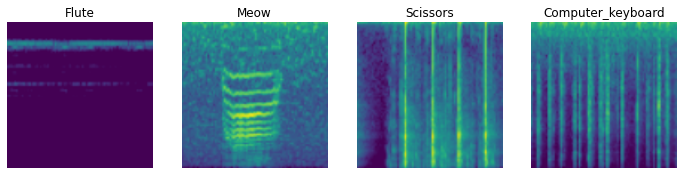

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

In [29]:
dls.one_batch()

(TensorImage([[[[0.2314, 0.2431, 0.2588,  ..., 0.2824, 0.2824, 0.2824],
           [0.2549, 0.2588, 0.2667,  ..., 0.2745, 0.2745, 0.2745],
           [0.2824, 0.2784, 0.2745,  ..., 0.2667, 0.2667, 0.2667],
           ...,
           [0.8196, 0.7882, 0.7373,  ..., 0.2667, 0.2667, 0.2667],
           [0.7529, 0.7137, 0.6588,  ..., 0.2667, 0.2667, 0.2667],
           [0.6667, 0.6275, 0.5686,  ..., 0.2667, 0.2667, 0.2667]],
 
          [[0.3176, 0.2863, 0.2431,  ..., 0.1333, 0.1294, 0.1255],
           [0.2353, 0.2000, 0.1569,  ..., 0.0784, 0.0745, 0.0706],
           [0.1255, 0.0902, 0.0431,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.8588, 0.8549, 0.8510,  ..., 0.0039, 0.0039, 0.0039],
           [0.8706, 0.8667, 0.8588,  ..., 0.0039, 0.0039, 0.0039],
           [0.8588, 0.8510, 0.8431,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.5412, 0.5333, 0.5216,  ..., 0.4510, 0.4471, 0.4431],
           [0.4980, 0.4784, 0.4549,  ..., 0.3961, 0.3961, 0.3922],
           [0.4431,

# Learn a model

We are using a `Convolutional Nureal Network`. CNNs are widely used for image classifications, and will serve us nicely. 

In [30]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

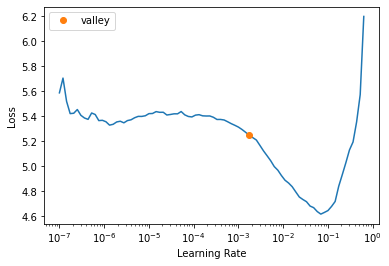

In [31]:
lr = learn.lr_find()

##### After 8 epochs the valid loss looks to flatten out a bit. and the accuracy doesn't look to get better. This looks to be a good time to stop training the model

In [32]:
learn.fine_tune(8, lr.valley)

# Evaluation

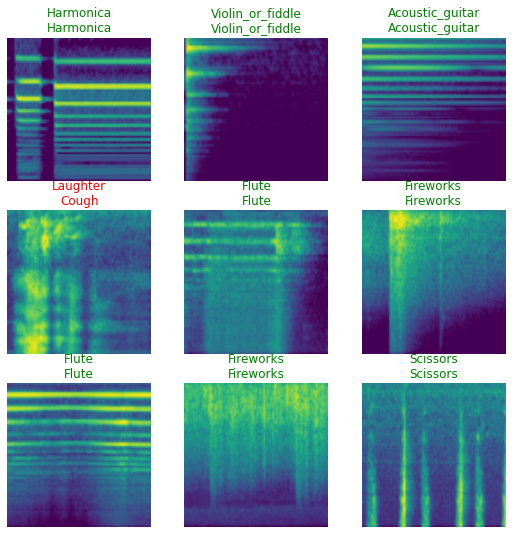

In [35]:
learn.show_results()

## Top losses

We can plot the cases where the model struggled the most. We can also play the sound of the recording where the model struggles. When listening to the audio clips it is easy to understand why the model is struggling. For example a sound labeled acoustic_guidar is the sound of someone slapping the wood of the guitar, which isn't very easily recognisable for a guitar.

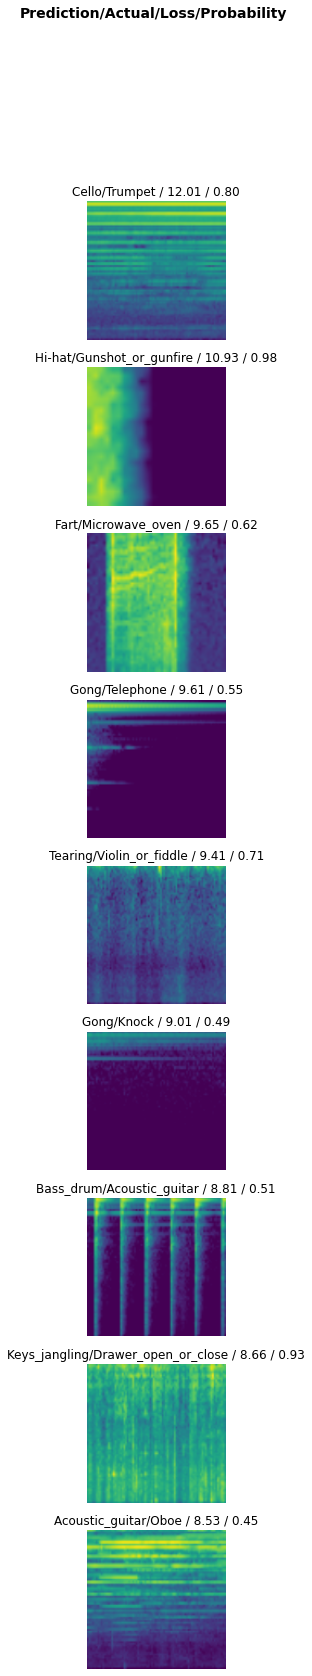

In [38]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9,nrows=9)

In [39]:
losses,idxs = interp.top_losses(9)
top_losses = [(dls.valid_ds.items[x]) for x in idxs]
for x in top_losses:
    filename = Path(x.name.split(".")[0])
    directory = AUDIO_RECORDINGS
    for file in os.listdir(directory):
        if str(filename) in file:
            print(f'{x.parent.name}')
            display(Audio(directory/file))

Trumpet


Gunshot_or_gunfire


Microwave_oven


Telephone


Violin_or_fiddle


Knock


Acoustic_guitar


Drawer_open_or_close


Oboe


## Confusion matrix

By plotting the confusion matrix we can se the prediction results. 

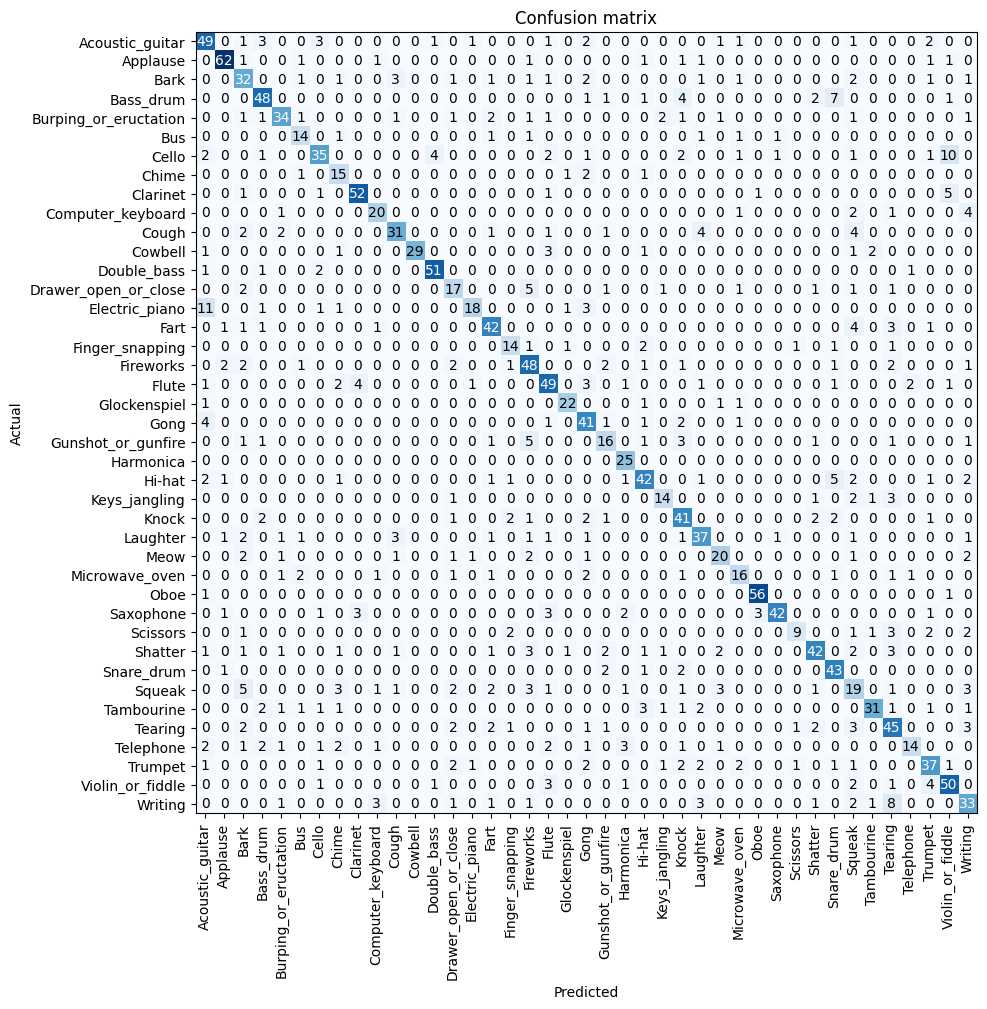

In [41]:
a = ClassificationInterpretation.from_learner(learn)
a.plot_confusion_matrix(figsize=(10,10), dpi = 100)

# Export

Ex

In [42]:
learn.export('../models/model_V2.pkl')